## Algoritmo de Grover

In [1]:
# Vamos a crear una lista sobre la cual queremos buscar un elemento

lista = [1,3,5,2,4,9,5,8,0,7,6]

In [2]:
# clasicamente podemos definir una caja negra a la cual le podemos preguntar si existe el numero 7
def oracle(input):
    winner = 7
    if  input is winner:
        response = True
    else:
        response = False
    return response

¿Cuántas veces debemos consultar nuestro oraculo antes de encontrar la solución?

In [4]:
for index, trial_number in enumerate(lista):
    if oracle(trial_number) is True:    # si el oraculo nos dice que el numero es el 7
        print(f"El numero 7 se encuentra en la posicion {index} de la lista")
        print(f"El numero de llamadas al oraculo fue {index+1}")
        break

El numero 7 se encuentra en la posicion 9 de la lista
El numero de llamadas al oraculo fue 10


En promedio necesitamos llamar nuestro oraculo $N/2$ y en el peor caso necesitamos llamar el oraculos $N$ veces. En computación clásica este problema escala como $Q(N)$. Ahora bien, lo increible de la computación cuántica es que este mismo problema escala como $O(\sqrt{N})$. Esto es lo que se conoce como la mejora cuadratica. 

***El oráculo*** en el caso cuántico es una fcunión que me dice nos da una señal si el input es el ganador, por lo que podemos codificar nuestras entradas como el conjunto base de una computadora cuántica, recuerden que dos qubits nos permiten resentar cuatro estados de entrada.

$$
\{ |00\rangle, |01\rangle, |10\rangle, |11\rangle \}
$$

Supongamos que nuestro gandor es el estado $|11\rangle$ al pasar este estado por el ***oráculo*** obtenemos $-|11\rangle$. La forma en la que podemos hacer estos cambios es haciendo uso de matrices unitarias $U_{unitaria}$ que podemos codificar en un circuito cuántico. En este caso queremos un circuito que cambie el signo del estado $|11\rangle$.

$$
U_{unitaria} |x\rangle = - |x\rangle
$$


In [5]:
import math

# Imports from Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution, plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler



In [6]:
# Para ejecutar en hardware, seleccione el backend con la menor cantidad de trabajos en la cola
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(f"Usando el backend: {backend.name}")

Usando el backend: ibm_kyiv


In [7]:
# Vamos a definir nueestro oraculo cuantico
def grover_oracle(selected_states):
    """
    Vamos a asumir que todos los estados tienen el mismo numero de bits

    Parameters:
    selected_states (str o list): Estados que queremos que el oraculo marque como correctos

    Returns:
        QuantumCircuit: Circuito que implementa el oraculo de Grover
    """
    if not isinstance(selected_states, list):
        selected_states = [selected_states]
    
    # Calcular el numero de quibits necesarios
    num_qubits = len(selected_states[0])

    # Definir los registros cuanticos
    qbits = QuantumRegister(num_qubits, name='q')
    qc = QuantumCircuit(qbits, name='Grover Oracle')

    # Marcar cada estado objetivo en la lista de entrada
    for target in selected_states:
        # invertir la cadena de bits para que coincida con el orden de bits de Qskit
        reversed_target = target[::-1]
        # Encontrar los indices de todos los elementos '0' en la cadena
        zeros_idx = [i for i in range(num_qubits) if reversed_target.startswith('0', i)]
        # Agregar un puerta Z multi-controlada con compuertas X antes y despues donde la cadena 
        # tiene un '0'
        qc.x(zeros_idx)
        qc.compose(MCMT(ZGate(),num_qubits-1,1), inplace=True)
        qc.x(zeros_idx)
    return qc



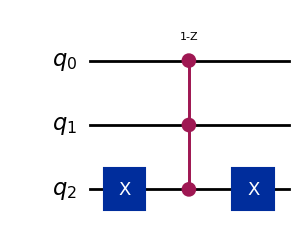

In [8]:
marked_states = ["011"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

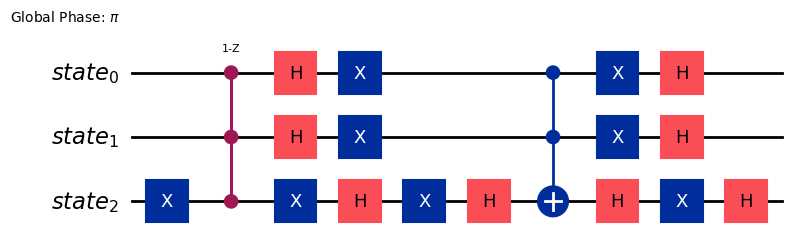

In [9]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [10]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

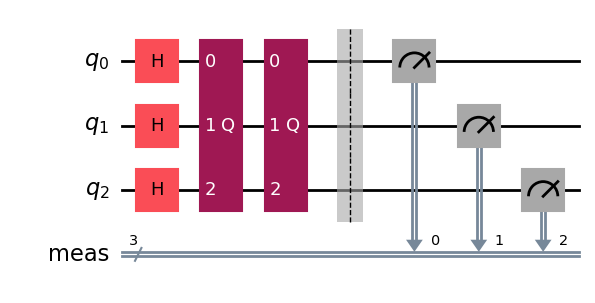

In [11]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

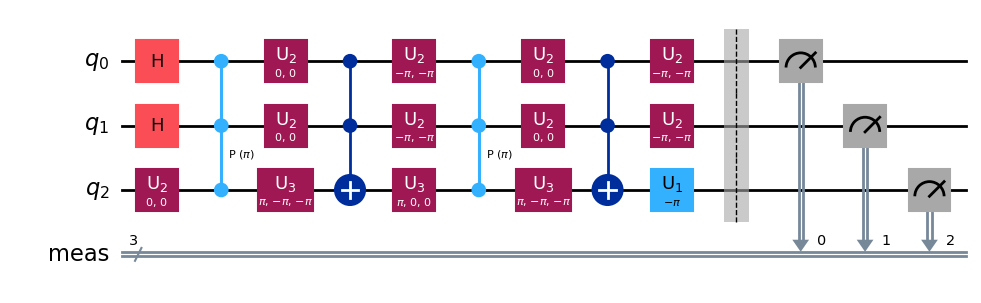

In [12]:

# Creamos el simulador cuántico
qasm_simulator = Aer.get_backend('qasm_simulator')

# Transpilamos el circuito para el backend
transpiled_qc = transpile(qc, qasm_simulator)
transpiled_qc.draw(output='mpl')    

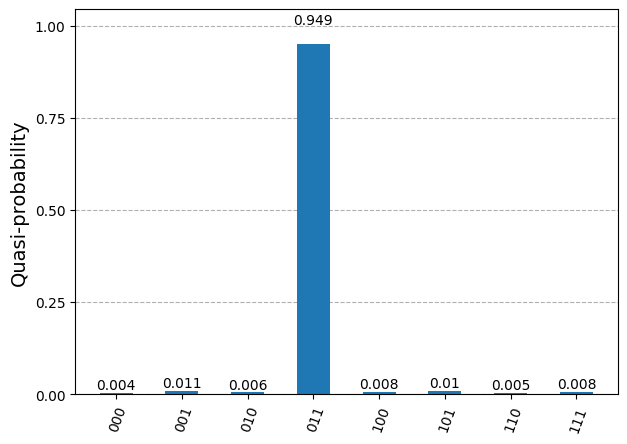

In [13]:

job = qasm_simulator.run(transpiled_qc, shots=1024)
result = job.result()

# Mostramos el histograma con los resultados
counts = result.get_counts()
plot_distribution(counts)

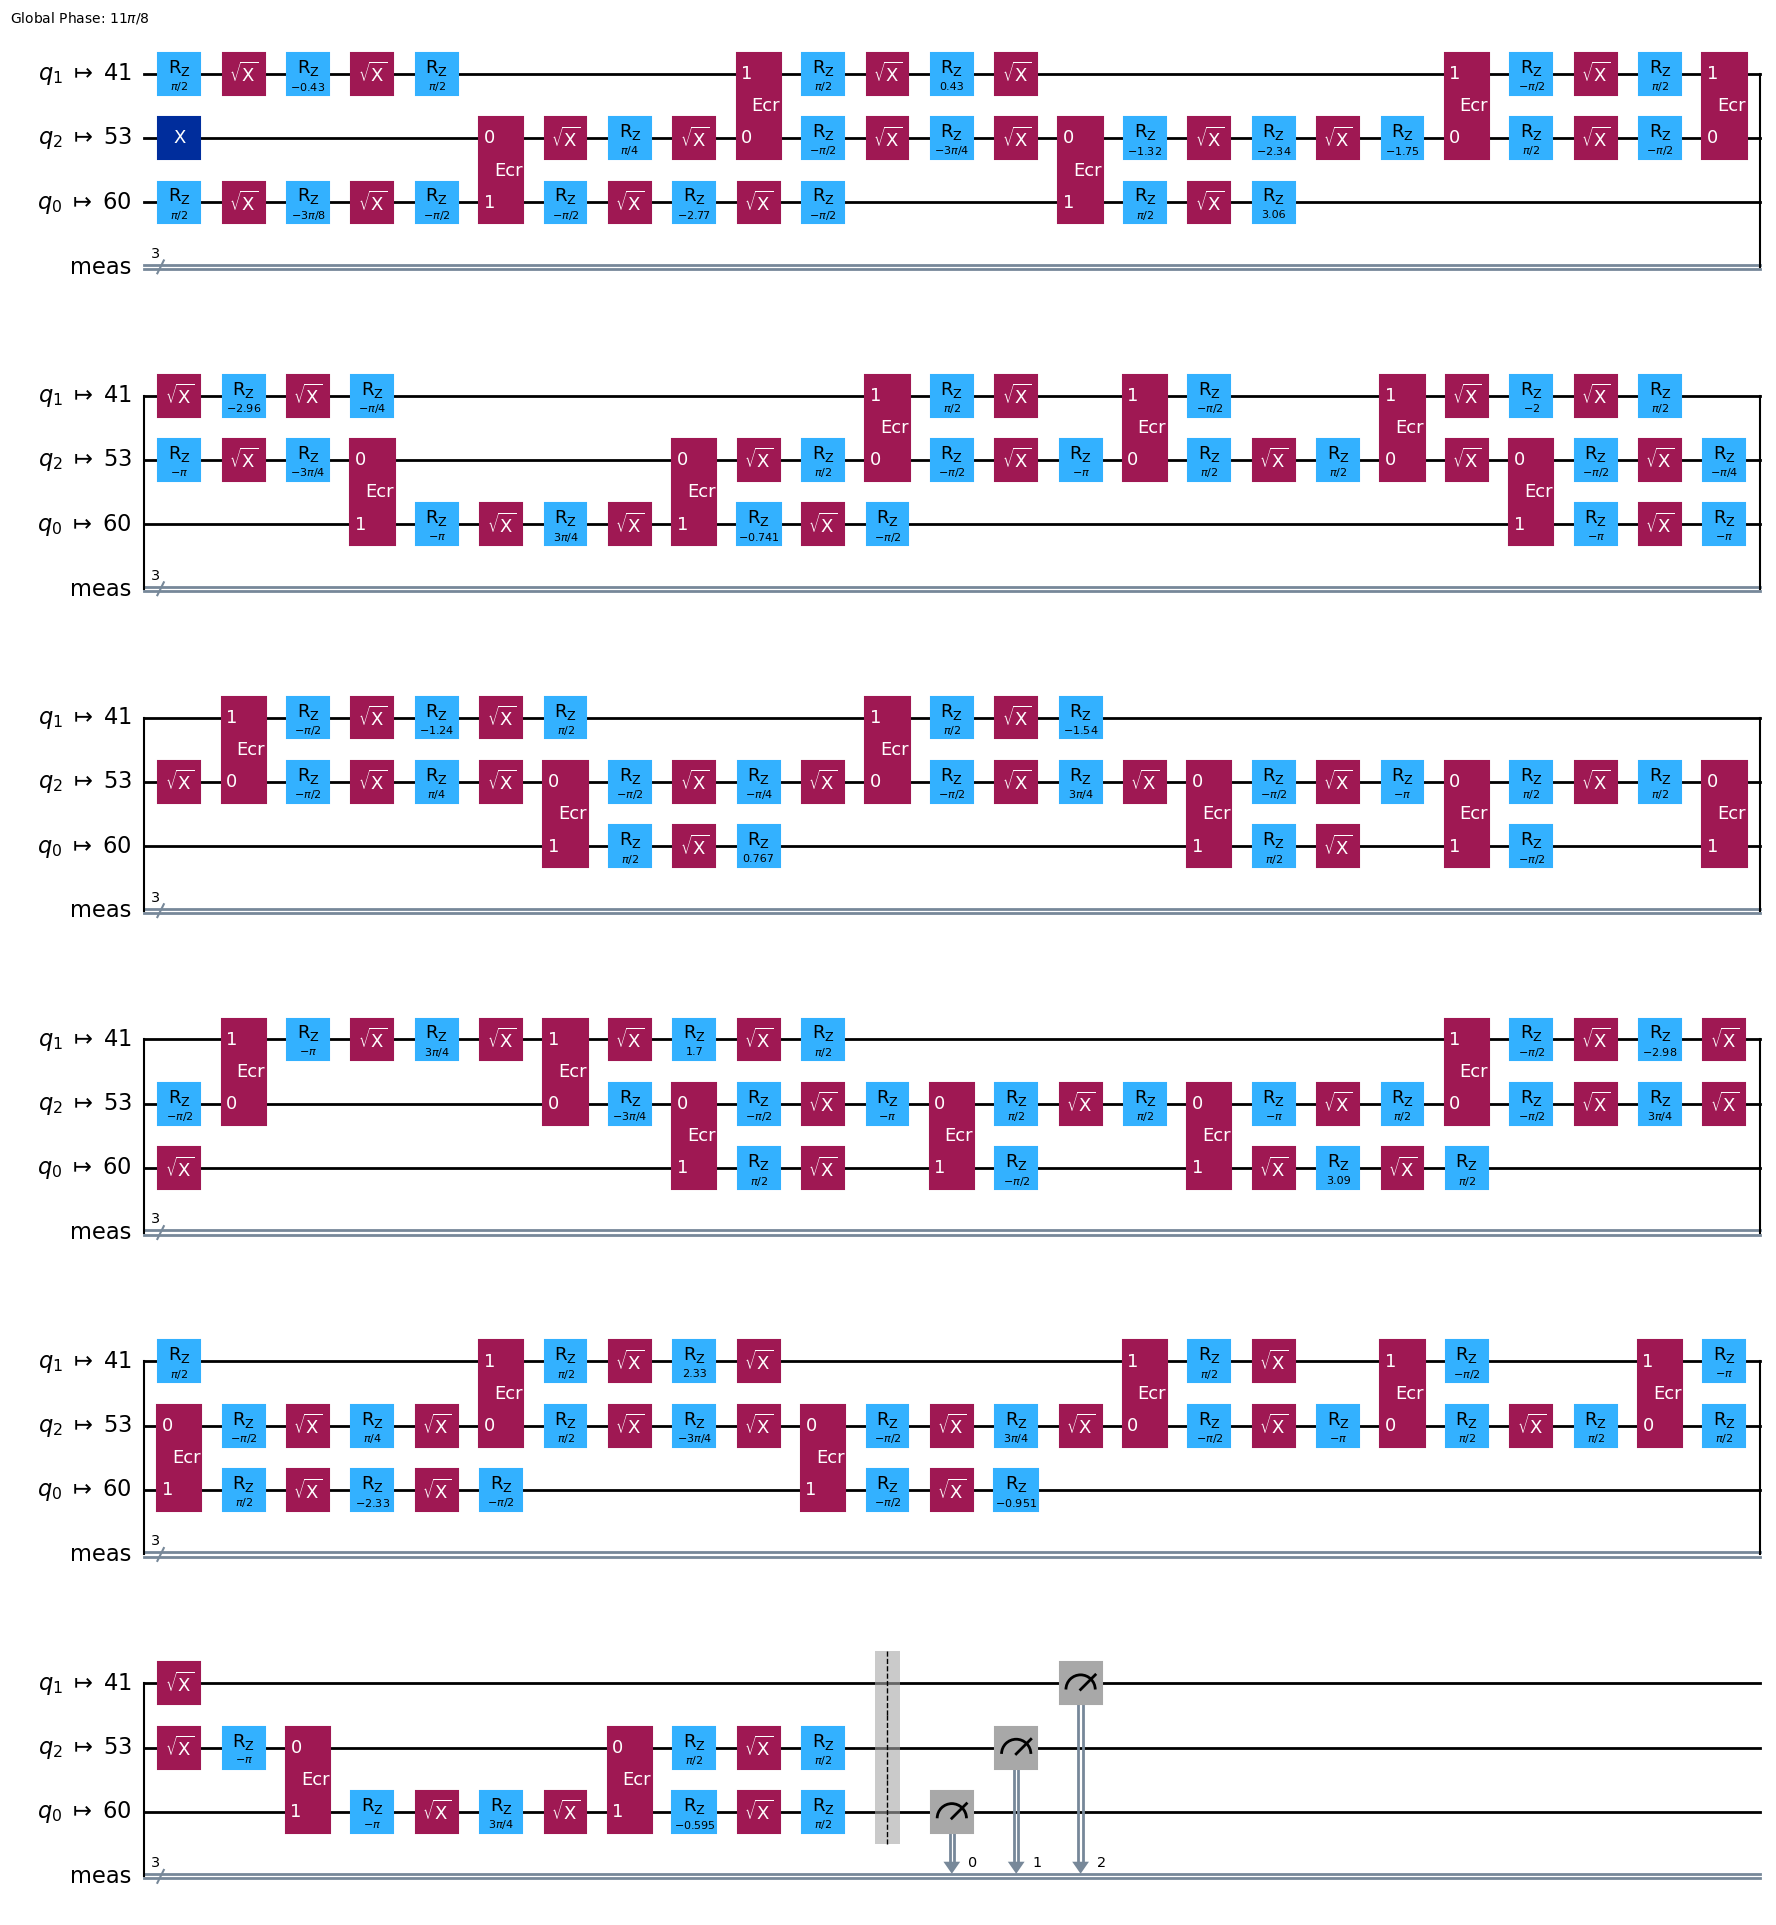

In [11]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [12]:
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
job = sampler.run([circuit_isa])
# Recuperar los resultados
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cxdkevbvw7kg008avpw0


In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='bd0b91e744904acd322a103a75e6803c5f96e228ae5958b369339a1e86cf2cf3bfd75065de732a7dc9290665dd3aac53d1ed79f5f3c958b0cd8ecd43006750be'
)
job = service.job('cxdkevbvw7kg008avpw0')
job_result = job.result()


pub_result = job_result[0].data.meas.get_counts()
plot_distribution(pub_result)